# Memory Retrieval Inductive Biases [`dev`]

- make memory retrieval symmetric
- gating

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from tqdm.keras import TqdmCallback

import itertools
import sys;sys.path.append('..')
import utils

import tensorflow as tf
from tensorflow.keras import layers

/Users/ruixiaowang/opt/anaconda3/envs/IML_env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-09-25 21:12:30.672865: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

## Generate Data

In [157]:
n_states = 30
m = 2

state_tuples = list(itertools.product(range(n_states), repeat=m))
len(state_tuples)

900

In [158]:
transition_dict = dict()

for state_tuple in state_tuples:
    next_state = np.random.randint(n_states)
    p = np.zeros(n_states)
    p[next_state] = 1

    transition_dict[state_tuple] = p

In [159]:
def sample_markov_chain(transition_dict, prefix, num_steps):
    states_seq = prefix
    m = len(list(transition_dict.keys())[0])

    for i in range(num_steps-m):
        probabilities = transition_dict[tuple(states_seq[-m:])]
        next_state = np.random.choice(range(n_states), p=probabilities)
        states_seq.append(next_state)
    return states_seq

In [160]:
input_seq_len = 32 # length of input sequences
mem_seq_len = 5*m # length of each memory sequence
mem_size = 16 # number of memory sequences

n_train = 400
n_test = 400

def sample_seqs_dataset(n, input_seq_len):
    seqs = np.array([sample_markov_chain(
        transition_dict, prefix=list(state_tuples[np.random.choice(len(state_tuples))]), num_steps=input_seq_len+1) for _ in range(n)])

    seqs_x = seqs[:, :-1]
    seqs_y = seqs[:, 1:]

    return seqs_x, seqs_y


def sample_mem_dataset(mem_seq_len, mem_size, input_seq=None, num_subseqs=1):
    mem_seqs = np.array([sample_markov_chain(
        transition_dict, prefix=list(state_tuples[np.random.choice(len(state_tuples))]), num_steps=mem_seq_len+1)
         for _ in range(mem_size)])
    # mem_seqs = np.repeat(np.expand_dims(mem_seqs, axis=0), axis=0, repeats=n)
    mem_seqs = mem_seqs

    mem_seqs_x = mem_seqs[:, :-1]
    mem_seqs_y = mem_seqs[:, 1:]

    if input_seq is not None:
        x_len = len(input_seq)
        for _ in range(num_subseqs):
            start_idx = np.random.randint(0, x_len - mem_seq_len - 1)
            x_subseq = input_seq[start_idx:start_idx+mem_seq_len]
            y_subseq = input_seq[start_idx+1:start_idx+1+mem_seq_len]

            mem_seqs_x = np.concatenate([mem_seqs_x, np.expand_dims(x_subseq, axis=0)])
            mem_seqs_y = np.concatenate([mem_seqs_y, np.expand_dims(y_subseq, axis=0)])

    return mem_seqs_x, mem_seqs_y

seqs_x_train, seqs_y_train = sample_seqs_dataset(n_train, input_seq_len)
seqs_x_test, seqs_y_test = sample_seqs_dataset(n_test, input_seq_len)

mem_seqs_x, mem_seqs_y = sample_mem_dataset(mem_seq_len, mem_size)


# sample memory buffers randomly
mem_seqs_x_train, mem_seqs_y_train = zip(*[sample_mem_dataset(mem_seq_len, mem_size, input_seq, num_subseqs=1) for input_seq in seqs_x_train])
mem_seqs_x_test, mem_seqs_y_test = zip(*[sample_mem_dataset(mem_seq_len, mem_size, input_seq, num_subseqs=1) for input_seq in seqs_x_test])

mem_seqs_x_train, mem_seqs_y_train = np.array(mem_seqs_x_train), np.array(mem_seqs_y_train)
mem_seqs_x_test, mem_seqs_y_test = np.array(mem_seqs_x_test), np.array(mem_seqs_y_test)

In [161]:
print(f'seqs_x_train.shape: {seqs_x_train.shape}; seqs_y_train.shape: {seqs_y_train.shape}') # shape [batch_size, seq_len]
print(f'mem_seqs_x_train.shape: {mem_seqs_x_train.shape}; mem_seqs_y.shape: {mem_seqs_y_train.shape}') # shape [batch_size, num_mem_seqs, mem_seq_len]

seqs_x_train.shape: (400, 32); seqs_y_train.shape: (400, 32)
mem_seqs_x_train.shape: (400, 17, 10); mem_seqs_y.shape: (400, 17, 10)


In [162]:
fit_kwargs = dict(epochs=30)

from tqdm.keras import TqdmCallback
from tqdm import tqdm
def create_callbacks():
    return [TqdmCallback(tqdm_class=tqdm)]

In [163]:
train_ds = tf.data.Dataset.from_tensor_slices(((seqs_x_train, mem_seqs_x_train, mem_seqs_y_train), seqs_y_train)).batch(64)
test_ds = tf.data.Dataset.from_tensor_slices(((seqs_x_test, mem_seqs_x_test, mem_seqs_y_test), seqs_y_test)).batch(64)

## Kernel Model (added the option of CrossAttn value = shifted memory)

$$
\begin{align*}
x^{(t)} &= (x_1^{(t)}, \ldots, x_{l_m}^{(t)})\\
y^{(t)} &= (x_2^{(t)}, \ldots, x_{l_m + 1}^{(t)})\\
x &= (x_1, \ldots, x_{l_x})
\end{align*}
$$

$$
\begin{align*}
E^{(t)} &\gets \mathrm{CausalSelfAttn}(x_1^{(t)}, \ldots, x_{l_m}^{(t)})\\
E &\gets \mathrm{CausalSelfAttn}(x_1, \ldots, x_{l_x})
\end{align*}
$$

$$
\mathrm{CrossAttn}(Q \gets E_i, K \gets E^{(t)}, V \gets E^{(t)} / y^{(t)})
$$

$$K(x_i, x^{(t)}) = \phi_q(\mathrm{CausalSelfAttn}(x_1, \ldots, x_i))^\top \phi_k(\mathrm{CausalSelfAttn}(x_1^{(t)}, \ldots, x_j^{(t)}))$$

$$\phi_q = \phi_k \neq \phi_v$$

$l_x \times l_m \times n_m \times n_h$

In [174]:
import tensorflow as tf
from tensorflow.keras import layers
from transformer_modules import AddPositionalEmbedding, MemoryAddPositionalEmbedding
from custom_attention import GlobalSelfAttention, CausalSelfAttention, CrossAttention

class KernelMemoryTransformer(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, key_dim, n_heads, ff_sizes, symmetric_attention=False, crossAttn_value_shifted=False, **kwargs):
        super().__init__(**kwargs)

        self.symmetric_attention = symmetric_attention
        self.crossAttn_value_shifted = crossAttn_value_shifted
        self.embedder = layers.Embedding(vocab_size, embedding_dim, name='embedder')
        self.pos_embedder_adder  = AddPositionalEmbedding(name='pos_embedder_adder')
        self.memory_pos_embedder_adder = MemoryAddPositionalEmbedding(name='mem_pos_embedder_adder')
        
        # gating
        self.gate_dense = tf.keras.layers.Dense(1, activation='sigmoid')
        #self.gate_dense = tf.keras.layers.Dense(self.vocab_size, activation='sigmoid') #might generate error  

        # different self-attention layers for input and memories for encoding sequences
        self.input_self_attention = CausalSelfAttention(num_heads=n_heads, key_dim=key_dim, name='self_attn')
        if symmetric_attention:
            self.memory_self_attention_layer = self.input_self_attention
        else:
            self.memory_self_attention_layer = GlobalSelfAttention(num_heads=n_heads, key_dim=key_dim, name='mem_self_attn')

        # create cross attention layer                             
        self.cross_attention_layer = CrossAttention(num_heads=n_heads, key_dim=key_dim, value_dim = key_dim, symmetric_attention=symmetric_attention, name='cross_attn')

        self.feedforward = tf.keras.Sequential([layers.Dense(z, activation='relu') for z in ff_sizes], name='feedforward')
        self.output_dense = layers.Dense(vocab_size, activation='softmax', name='output')

    def memory_self_attention(self, mem_seqs):
        '''apply self-attention to each memory sequence'''
        lambda_fn = lambda x: self.memory_self_attention_layer(x)
        return tf.map_fn(lambda_fn, mem_seqs)

    def get_cross_probs(self, embedded_input_seqs, embedded_mem_x_seqs, embedded_mem_y_seqs):
        '''compute cross attention probabilities prob(x_{i+1} = . | x_{1:i}, x^{(t)}) for each memory'''
       
        def get_memory_cross_probs(Et, Et_y):
            cross_attention_output = self.cross_attention_layer(
                x=embedded_input_seqs,
                context=Et,
                y=Et_y)
            return cross_attention_output # shape: (batch_size, seq_len, mem_len)

        # compute cross-attention for each memory
        embedded_mem_x_seqs = tf.transpose(embedded_mem_x_seqs, perm=[1, 0, 2, 3])
        if self.crossAttn_value_shifted:
            embedded_mem_y_seqs = tf.transpose(embedded_mem_y_seqs, perm=[1, 0, 2, 3]) 
        else:
             embedded_mem_y_seqs =  embedded_mem_x_seqs
             
        cross_probs = tf.map_fn(lambda xy: get_memory_cross_probs(xy[0], xy[1]), 
                            (embedded_mem_x_seqs, embedded_mem_y_seqs),
                            dtype=tf.float32)
        cross_probs = tf.transpose(cross_probs, perm=[1, 0, 2, 3]) # shape: (batch_size, n_mem, mem_length, embedding_dim)

        # compute cross-probs from cross-attention via feedforward network
        cross_probs = self.feedforward(cross_probs)
        cross_probs = self.output_dense(cross_probs) # shape: (batch_size, n_mems, mem_length, vocab_size)

        return cross_probs

    def get_observed_cross_probs(self, cross_probs, seq_input):
        '''given the cross_probs tensor, extract the components corresponding to the observed sequence'''

        cross_probs_observed = tf.transpose(cross_probs, perm=(1,0,2,3))
        cross_probs_observed = tf.map_fn(lambda x: tf.gather(x, indices=seq_input, axis=-1, batch_dims=2), cross_probs_observed)
        cross_probs_observed = tf.transpose(cross_probs_observed, perm=(1,0,2))
        return cross_probs_observed

    def compute_mem_attention_scores(self, cross_probs_observed):
        '''compute memory-level attention scores, alpha_it (i is position in input sequence, t is memory index)'''

        log_cross_probs_observed = tf.math.log(cross_probs_observed)
        w_it = tf.math.cumsum(log_cross_probs_observed, axis=-1, exclusive=True)
        alpha_it = tf.nn.softmax(w_it, axis=1) # shape [batch_size, num_mems, in_seq_length]
        return alpha_it  
     
    
    def call(self, inputs):
        
        # handle crossAttn value
        embedded_mem_y_seqs = None
        if self.crossAttn_value_shifted:
            seq_input, memory_input, memory_output = inputs
            embedded_mem_y_seqs = self.embedder(memory_output)
            embedded_mem_y_seqs = self.memory_pos_embedder_adder(embedded_mem_y_seqs)
        else:
            seq_input, memory_input = inputs
        

        # embed input sequences and memory sequences
        embedded_input_seqs = self.embedder(seq_input)
        embedded_mem_x_seqs = self.embedder(memory_input)

        # add positional embeddings
        embedded_input_seqs = self.pos_embedder_adder(embedded_input_seqs)
        embedded_mem_x_seqs = self.memory_pos_embedder_adder(embedded_mem_x_seqs)

        # encode via self-attention
        embedded_input_seqs = self.input_self_attention(embedded_input_seqs) # shape: (batch_size, input_length, embedding_dim)
        embedded_mem_x_seqs = self.memory_self_attention(embedded_mem_x_seqs) # shape: (batch_size, num_memories, memory_length, embedding_dim)

        # normal transformer (only encoder)
        # cross_probs = self.input_self_attention(embedded_input_seqs, embedded_input_seqs, embedded_input_seqs)
        cross_probs = self.feedforward(embedded_input_seqs)
        cross_probs = self.output_dense(cross_probs)
        encoder_output = tf.nn.softmax(cross_probs, axis=-1)
        
    
        # compute prob(x_{i+1} = . | x_{1:i}, x^{(t)}) for each memory
        cross_probs_mem_on = self.get_cross_probs(embedded_input_seqs, embedded_mem_x_seqs, embedded_mem_y_seqs)

        # compute prob(x_{i+1} | x_{1:i}, x^{(t)}) for each memory
        cross_probs_observed = self.get_observed_cross_probs(cross_probs_mem_on, seq_input)

        # compute alpha_it = softmax(w_it) where w_it = sum_{j=1}^{i-1} log prob(x_{j+1} | x_{1:j}, x^{(t)})
        alpha_it = self.compute_mem_attention_scores(cross_probs_observed)
        self.alpha_it = alpha_it

        # compute prob(x_{i+1} | x_{1:i}, {x^{(t)}}_t) = \sum_t alpha_it * prob(x_{i+1} = . | x_{1:i}, x^{(t)})
        output = tf.reduce_sum(tf.multiply(tf.expand_dims(alpha_it, axis=-1), cross_probs_mem_on), axis=1)

        return output


### Kernel Model with Memory Only: symmetric_attention = True, crossAttn_value_shifted = True

In [175]:
vocab_size = n_states
embedding_dim = 64
kernel_model_cross_y = KernelMemoryTransformer(
    vocab_size, embedding_dim=embedding_dim,
    key_dim=embedding_dim//4, n_heads=4, ff_sizes = [vocab_size,], symmetric_attention = True, crossAttn_value_shifted = True, name='kernel_model_cross_y')


kernel_model_cross_y([seqs_x_train[:64], mem_seqs_x_train[:64], mem_seqs_y_train[:64]]); # build model
create_opt = lambda: tf.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
kernel_model_cross_y.compile(optimizer=create_opt(), loss=loss, metrics=['accuracy'])
kernel_model_cross_y.summary()

Model: "kernel_model_cross_y"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedder (Embedding)        multiple                  1920      
                                                                 
 pos_embedder_adder (AddPosi  multiple                 0         
 tionalEmbedding)                                                
                                                                 
 mem_pos_embedder_adder (Mem  multiple                 0         
 oryAddPositionalEmbedding)                                      
                                                                 
 dense_679 (Dense)           multiple                  0 (unused)
                                                                 
 causal_self_attention_36 (C  multiple                 12608     
 ausalSelfAttention)                                             
                                              

  0%|          | 0/30 [00:00<?, ?epoch/s]

100%|██████████| 30/30 [00:38<00:00,  1.29s/epoch, loss=0.651, accuracy=0.839, val_loss=0.702, val_accuracy=0.827]


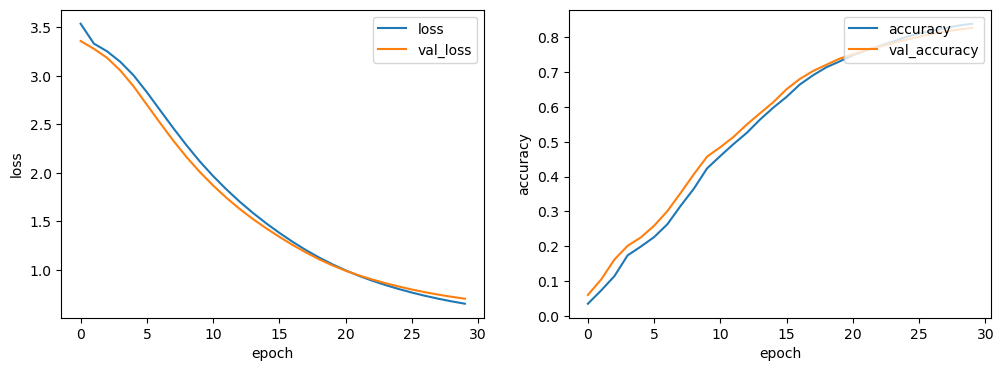

In [176]:
history3 = kernel_model_cross_y.fit(train_ds, validation_data=test_ds, verbose=0, callbacks=create_callbacks(), **fit_kwargs)
utils.plot_history(history3, plot_attrs=('loss', 'accuracy'), val=True, figsize=(12,4));

7/7 [==============================] - 1s 58ms/step


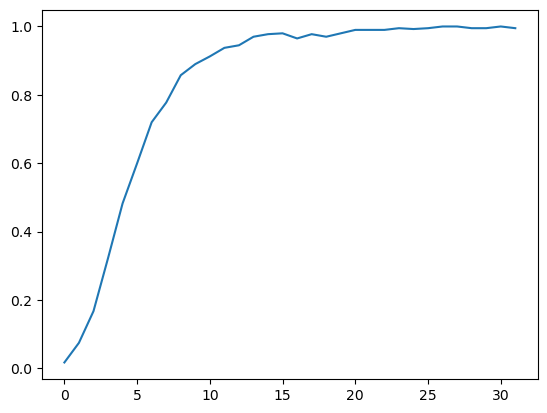

In [177]:
# plot accuracy as a function of position in sequence
preds = kernel_model_cross_y.predict(test_ds)
preds = np.argmax(preds, axis=-1)
acc_by_pos = np.mean(preds == seqs_y_test, axis=0)
plt.plot(acc_by_pos)

kernel_model_cross_y
sample_input:  [[ 9  6 26  3  5  0  4 27 12 15  8  8 18  3 17 13 23 23  4  8 14 19 14  2
  10  2 11 13 21  1 21 13]]
prediction: [25 20  1  5  0  4 27 12 15  8  8 18  3 17 13 23 23  4  8 14 19 14  2 10
  2 11 13 21  1 21 13  0]
y: [ 6 26  3  5  0  4 27 12 15  8  8 18  3 17 13 23 23  4  8 14 19 14  2 10
  2 11 13 21  1 21 13  0]
[False False False  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]


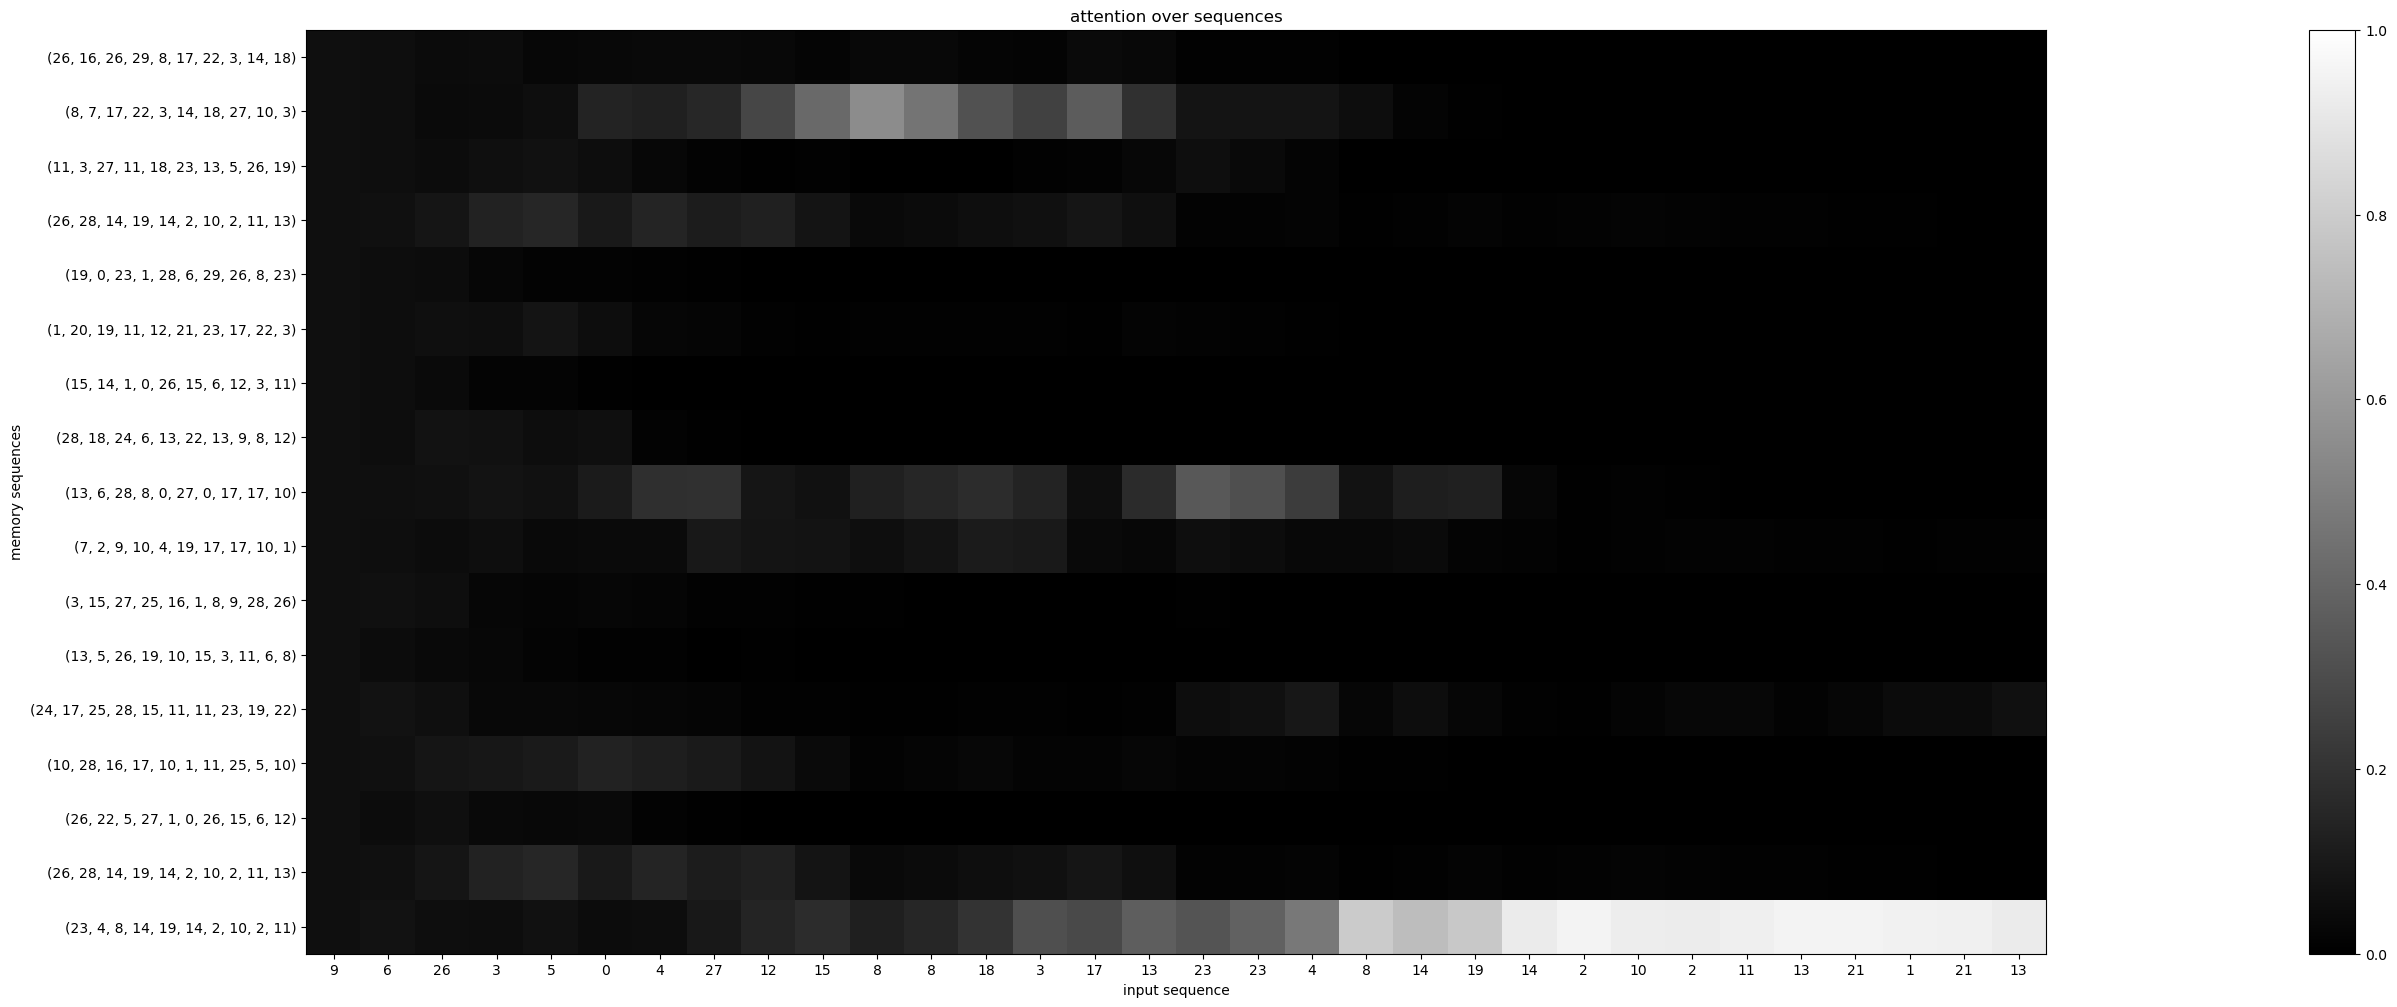

In [180]:
from utils_kernel_transformer import plot_attention, plot_seq_attention, plot_attention_cross_y

    
mem_seqs_x_train, mem_seqs_y_train = zip(*[sample_mem_dataset(mem_seq_len, mem_size, input_seq, num_subseqs=1) for input_seq in seqs_x_train])
mem_seqs_x_test, mem_seqs_y_test = zip(*[sample_mem_dataset(mem_seq_len, mem_size, input_seq, num_subseqs=1) for input_seq in seqs_x_test])

mem_seqs_x_train, mem_seqs_y_train = np.array(mem_seqs_x_train), np.array(mem_seqs_y_train)
mem_seqs_x_test, mem_seqs_y_test = np.array(mem_seqs_x_test), np.array(mem_seqs_y_test)

idx = np.random.choice(len(seqs_x_test))
print('kernel_model_cross_y')

plot_attention_cross_y(idx, seqs_x_test, seqs_y_test, mem_seqs_x_test, mem_seqs_y_test, kernel_model_cross_y)


In [181]:
accs = []
nums_subseqs = [0, 1, 2, 4, 8, 16]
for num_subseqs in tqdm(nums_subseqs):
    mem_seqs_x_test, mem_seqs_y_test = zip(*[sample_mem_dataset(mem_seq_len, mem_size, input_seq, num_subseqs=num_subseqs) for input_seq in seqs_x_test])
    mem_seqs_x_test, mem_seqs_y_test = np.array(mem_seqs_x_test), np.array(mem_seqs_y_test)

    test_ds = tf.data.Dataset.from_tensor_slices(((seqs_x_test, mem_seqs_x_test, mem_seqs_y_test), seqs_y_test)).batch(64)
    _, acc = kernel_model_cross_y.evaluate(test_ds, verbose=0)
    accs.append(acc)

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:10<00:00,  1.79s/it]


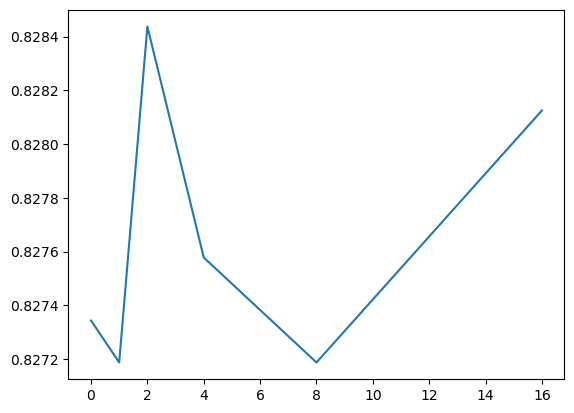

In [182]:
plt.plot(nums_subseqs, accs)

## Add Gating

$$
\begin{align*}
x^{(t)} &= (x_1^{(t)}, \ldots, x_{l_m}^{(t)})\\
y^{(t)} &= (x_2^{(t)}, \ldots, x_{l_m + 1}^{(t)})\\
x &= (x_1, \ldots, x_{l_x})
\end{align*}
$$

$$
\begin{align*}
E^{(t)} &\gets \mathrm{CausalSelfAttn}(x_1^{(t)}, \ldots, x_{l_m}^{(t)})\\
E &\gets \mathrm{CausalSelfAttn}(x_1, \ldots, x_{l_x})
\end{align*}
$$

With memory turned off (normal transformer with encoder only):
$$
\mathrm{output} \gets softmax(Dense(FFN(x)))
$$

With memory on (episodic transformer):
$$
\mathrm{CrossAttn}(Q \gets E_i, K \gets E^{(t)}, V \gets E^{(t)} / y^{(t)})
$$

$$K(x_i, x^{(t)}) = \phi_q(\mathrm{CausalSelfAttn}(x_1, \ldots, x_i))^\top \phi_k(\mathrm{CausalSelfAttn}(x_1^{(t)}, \ldots, x_j^{(t)}))$$

$$\mathrm{gated output} \gets (1-\lambda) \mathrm{output} + \lambda (\mathrm{et\_ output})$$

In [202]:
import tensorflow as tf
from tensorflow.keras import layers
from transformer_modules import AddPositionalEmbedding, MemoryAddPositionalEmbedding
from custom_attention import GlobalSelfAttention, CausalSelfAttention, CrossAttention

class KernelMemoryTransformer(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, key_dim, n_heads, ff_sizes, symmetric_attention=False, crossAttn_value_shifted=False, memory_on = True, **kwargs):
        super().__init__(**kwargs)

        self.symmetric_attention = symmetric_attention
        self.crossAttn_value_shifted = crossAttn_value_shifted
        self.memory_on = memory_on
        self.embedder = layers.Embedding(vocab_size, embedding_dim, name='embedder')
        self.pos_embedder_adder  = AddPositionalEmbedding(name='pos_embedder_adder')
        self.memory_pos_embedder_adder = MemoryAddPositionalEmbedding(name='mem_pos_embedder_adder')
        
        # gating
        self.gate_dense = tf.keras.layers.Dense(1, activation='sigmoid')
        #self.gate_dense = tf.keras.layers.Dense(self.vocab_size, activation='sigmoid') #might generate error  

        # different self-attention layers for input and memories for encoding sequences
        self.input_self_attention = CausalSelfAttention(num_heads=n_heads, key_dim=key_dim, name='self_attn')
        if symmetric_attention:
            self.memory_self_attention_layer = self.input_self_attention
        else:
            self.memory_self_attention_layer = GlobalSelfAttention(num_heads=n_heads, key_dim=key_dim, name='mem_self_attn')

        # create cross attention layer                             
        self.cross_attention_layer = CrossAttention(num_heads=n_heads, key_dim=key_dim, value_dim = key_dim, symmetric_attention=symmetric_attention, name='cross_attn')

        self.feedforward = tf.keras.Sequential([layers.Dense(z, activation='relu') for z in ff_sizes], name='feedforward')
        self.output_dense = layers.Dense(vocab_size, activation='softmax', name='output')

    def memory_self_attention(self, mem_seqs):
        '''apply self-attention to each memory sequence'''
        lambda_fn = lambda x: self.memory_self_attention_layer(x)
        return tf.map_fn(lambda_fn, mem_seqs)

    def get_cross_probs(self, embedded_input_seqs, embedded_mem_x_seqs, embedded_mem_y_seqs):
        '''compute cross attention probabilities prob(x_{i+1} = . | x_{1:i}, x^{(t)}) for each memory'''
       
        def get_memory_cross_probs(Et, Et_y):
            cross_attention_output = self.cross_attention_layer(
                x=embedded_input_seqs,
                context=Et,
                y=Et_y)
            return cross_attention_output # shape: (batch_size, seq_len, mem_len)

        # compute cross-attention for each memory
        embedded_mem_x_seqs = tf.transpose(embedded_mem_x_seqs, perm=[1, 0, 2, 3])
        if self.crossAttn_value_shifted:
            embedded_mem_y_seqs = tf.transpose(embedded_mem_y_seqs, perm=[1, 0, 2, 3]) 
        else:
             embedded_mem_y_seqs =  embedded_mem_x_seqs
             
        cross_probs = tf.map_fn(lambda xy: get_memory_cross_probs(xy[0], xy[1]), 
                            (embedded_mem_x_seqs, embedded_mem_y_seqs),
                            dtype=tf.float32)
        cross_probs = tf.transpose(cross_probs, perm=[1, 0, 2, 3]) # shape: (batch_size, n_mem, mem_length, embedding_dim)

        # compute cross-probs from cross-attention via feedforward network
        cross_probs = self.feedforward(cross_probs)
        cross_probs = self.output_dense(cross_probs) # shape: (batch_size, n_mems, mem_length, vocab_size)

        return cross_probs

    def get_observed_cross_probs(self, cross_probs, seq_input):
        '''given the cross_probs tensor, extract the components corresponding to the observed sequence'''

        cross_probs_observed = tf.transpose(cross_probs, perm=(1,0,2,3))
        cross_probs_observed = tf.map_fn(lambda x: tf.gather(x, indices=seq_input, axis=-1, batch_dims=2), cross_probs_observed)
        cross_probs_observed = tf.transpose(cross_probs_observed, perm=(1,0,2))
        return cross_probs_observed

    def compute_mem_attention_scores(self, cross_probs_observed):
        '''compute memory-level attention scores, alpha_it (i is position in input sequence, t is memory index)'''

        log_cross_probs_observed = tf.math.log(cross_probs_observed)
        w_it = tf.math.cumsum(log_cross_probs_observed, axis=-1, exclusive=True)
        alpha_it = tf.nn.softmax(w_it, axis=1) # shape [batch_size, num_mems, in_seq_length]
        return alpha_it  
     
    
    def call(self, inputs):
        
        # handle crossAttn value
        embedded_mem_y_seqs = None
        if self.crossAttn_value_shifted:
            seq_input, memory_input, memory_output = inputs
            embedded_mem_y_seqs = self.embedder(memory_output)
            embedded_mem_y_seqs = self.memory_pos_embedder_adder(embedded_mem_y_seqs)
        else:
            seq_input, memory_input = inputs
        

        # embed input sequences and memory sequences
        embedded_input_seqs = self.embedder(seq_input)
        embedded_mem_x_seqs = self.embedder(memory_input)

        # add positional embeddings
        embedded_input_seqs = self.pos_embedder_adder(embedded_input_seqs)
        embedded_mem_x_seqs = self.memory_pos_embedder_adder(embedded_mem_x_seqs)

        # encode via self-attention
        embedded_input_seqs = self.input_self_attention(embedded_input_seqs) # shape: (batch_size, input_length, embedding_dim)
        embedded_mem_x_seqs = self.memory_self_attention(embedded_mem_x_seqs) # shape: (batch_size, num_memories, memory_length, embedding_dim)

        # normal transformer (only encoder)
        # cross_probs = self.input_self_attention(embedded_input_seqs, embedded_input_seqs, embedded_input_seqs)
        cross_probs = self.feedforward(embedded_input_seqs)
        encoder_output = self.output_dense(cross_probs) # softmax in output_dense
        
        if self.memory_on: 
            # compute prob(x_{i+1} = . | x_{1:i}, x^{(t)}) for each memory
            cross_probs_mem_on = self.get_cross_probs(embedded_input_seqs, embedded_mem_x_seqs, embedded_mem_y_seqs)

            # compute prob(x_{i+1} | x_{1:i}, x^{(t)}) for each memory
            cross_probs_observed = self.get_observed_cross_probs(cross_probs_mem_on, seq_input)

            # compute alpha_it = softmax(w_it) where w_it = sum_{j=1}^{i-1} log prob(x_{j+1} | x_{1:j}, x^{(t)})
            alpha_it = self.compute_mem_attention_scores(cross_probs_observed)
            self.alpha_it = alpha_it

            # compute prob(x_{i+1} | x_{1:i}, {x^{(t)}}_t) = \sum_t alpha_it * prob(x_{i+1} = . | x_{1:i}, x^{(t)})
            mem_on_output = tf.reduce_sum(tf.multiply(tf.expand_dims(alpha_it, axis=-1), cross_probs_mem_on), axis=1)
        
            # if turning on memory, then gate between two outputs
            gate = self.gate_dense(mem_on_output)
            self.gate = gate
            output = tf.multiply(gate, mem_on_output) + tf.multiply((1-gate), encoder_output)
        else:
            output = encoder_output
            

        return output


### Kernel Model Symmetric Attn, crossAttn value shifted, memory turned off

In [203]:
vocab_size = n_states
embedding_dim = 64
kernel_model_no_mem = KernelMemoryTransformer(
    vocab_size, embedding_dim=embedding_dim,
    key_dim=embedding_dim//4, n_heads=4, ff_sizes = [vocab_size,], symmetric_attention = True, crossAttn_value_shifted = True, memory_on = False, name='kernel_model_cross_y')


kernel_model_no_mem([seqs_x_train[:64], mem_seqs_x_train[:64], mem_seqs_y_train[:64]]); # build model
create_opt = lambda: tf.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
kernel_model_no_mem.compile(optimizer=create_opt(), loss=loss, metrics=['accuracy'])
kernel_model_no_mem.summary()

Model: "kernel_model_cross_y"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedder (Embedding)        multiple                  1920      
                                                                 
 pos_embedder_adder (AddPosi  multiple                 0         
 tionalEmbedding)                                                
                                                                 
 mem_pos_embedder_adder (Mem  multiple                 0         
 oryAddPositionalEmbedding)                                      
                                                                 
 dense_809 (Dense)           multiple                  0 (unused)
                                                                 
 causal_self_attention_43 (C  multiple                 12608     
 ausalSelfAttention)                                             
                                              

100%|██████████| 30/30 [00:08<00:00,  3.50epoch/s, loss=0.663, accuracy=0.833, val_loss=0.709, val_accuracy=0.827]


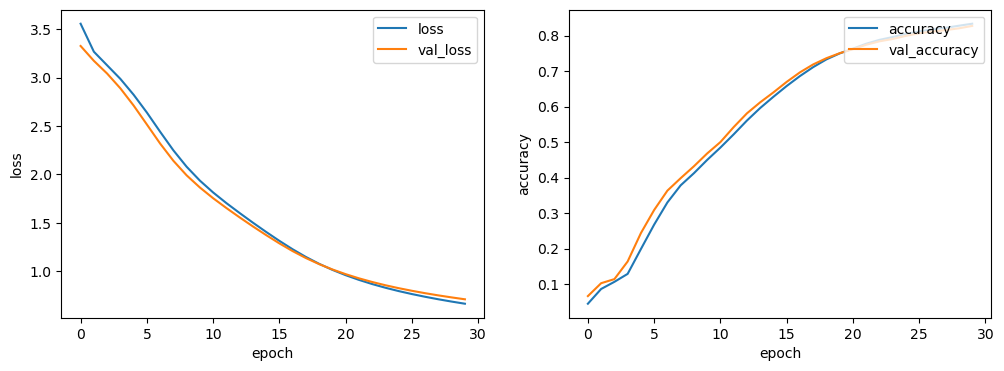

In [204]:
history1 = kernel_model_no_mem.fit(train_ds, validation_data=test_ds, verbose=0, callbacks=create_callbacks(), **fit_kwargs)
utils.plot_history(history1, plot_attrs=('loss', 'accuracy'), val=True, figsize=(12,4));

7/7 [==============================] - 1s 16ms/step


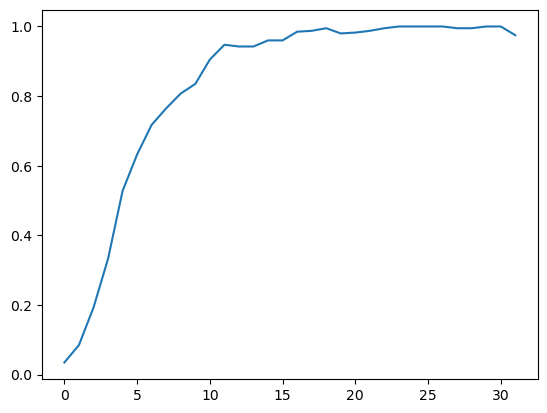

In [205]:
# plot accuracy as a function of position in sequence
preds = kernel_model_no_mem.predict(test_ds)
preds = np.argmax(preds, axis=-1)
acc_by_pos = np.mean(preds == seqs_y_test, axis=0)
plt.plot(acc_by_pos)

### Turn on the memory (with gating)

In [206]:
vocab_size = n_states
embedding_dim = 64
kernel_model_gating = KernelMemoryTransformer(
    vocab_size, embedding_dim=embedding_dim,
    key_dim=embedding_dim//4, n_heads=4, ff_sizes = [vocab_size,], symmetric_attention = True, crossAttn_value_shifted = True, memory_on = True, name='kernel_model_cross_y')


kernel_model_gating([seqs_x_train[:64], mem_seqs_x_train[:64], mem_seqs_y_train[:64]]); # build model
create_opt = lambda: tf.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
kernel_model_gating.compile(optimizer=create_opt(), loss=loss, metrics=['accuracy'])
kernel_model_gating.summary()

Model: "kernel_model_cross_y"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedder (Embedding)        multiple                  1920      
                                                                 
 pos_embedder_adder (AddPosi  multiple                 0         
 tionalEmbedding)                                                
                                                                 
 mem_pos_embedder_adder (Mem  multiple                 0         
 oryAddPositionalEmbedding)                                      
                                                                 
 dense_823 (Dense)           multiple                  31        
                                                                 
 causal_self_attention_44 (C  multiple                 12608     
 ausalSelfAttention)                                             
                                              

  0%|          | 0/30 [00:00<?, ?epoch/s]

100%|██████████| 30/30 [00:40<00:00,  1.34s/epoch, loss=0.64, accuracy=0.843, val_loss=0.687, val_accuracy=0.837] 


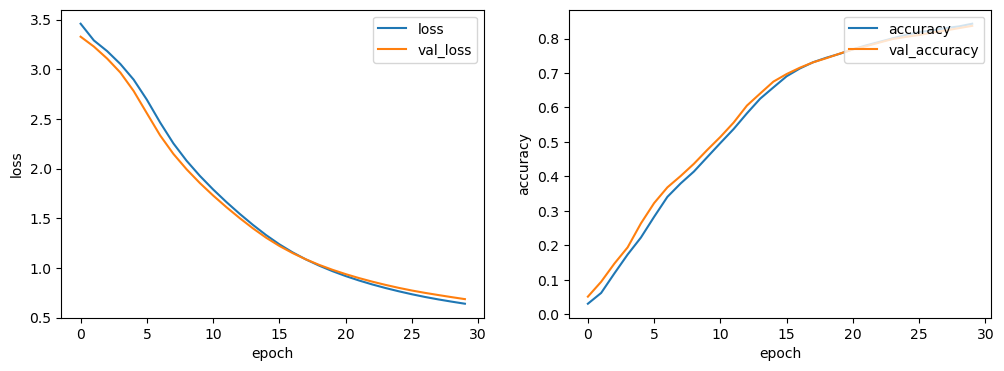

In [207]:
history2 = kernel_model_gating.fit(train_ds, validation_data=test_ds, verbose=0, callbacks=create_callbacks(), **fit_kwargs)
utils.plot_history(history2, plot_attrs=('loss', 'accuracy'), val=True, figsize=(12,4));

sample_input:  [[15 15 18 13  2 25 15  0  2 17 24 13 13 25 10 16  9 26  1  3 16  4  3 12
  27 22 29  8 17 22  3 14]]
prediction: [ 8  8 15  8  8 28 11  2 17 24 13 13 25 10 16  9 26  1  3 16  4  3 12 27
 22 29  8 17 22  3 14 18]
y: [15 18 13  2 25 15  0  2 17 24 13 13 25 10 16  9 26  1  3 16  4  3 12 27
 22 29  8 17 22  3 14 18]
[False False False False False False False  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]
Gate: [[0.5133305  0.51364046 0.49383977 0.50961816 0.5295688  0.4924835
  0.49092653 0.48984337 0.49772078 0.5372898  0.58189356 0.53837985
  0.5182633  0.5182503  0.42340738 0.41423815 0.5982192  0.5193974
  0.5196633  0.41522622 0.5953883  0.5185463  0.4438766  0.432024
  0.47004154 0.5242686  0.57765186 0.5133059  0.47188923 0.5188113
  0.5275704  0.58828247]]


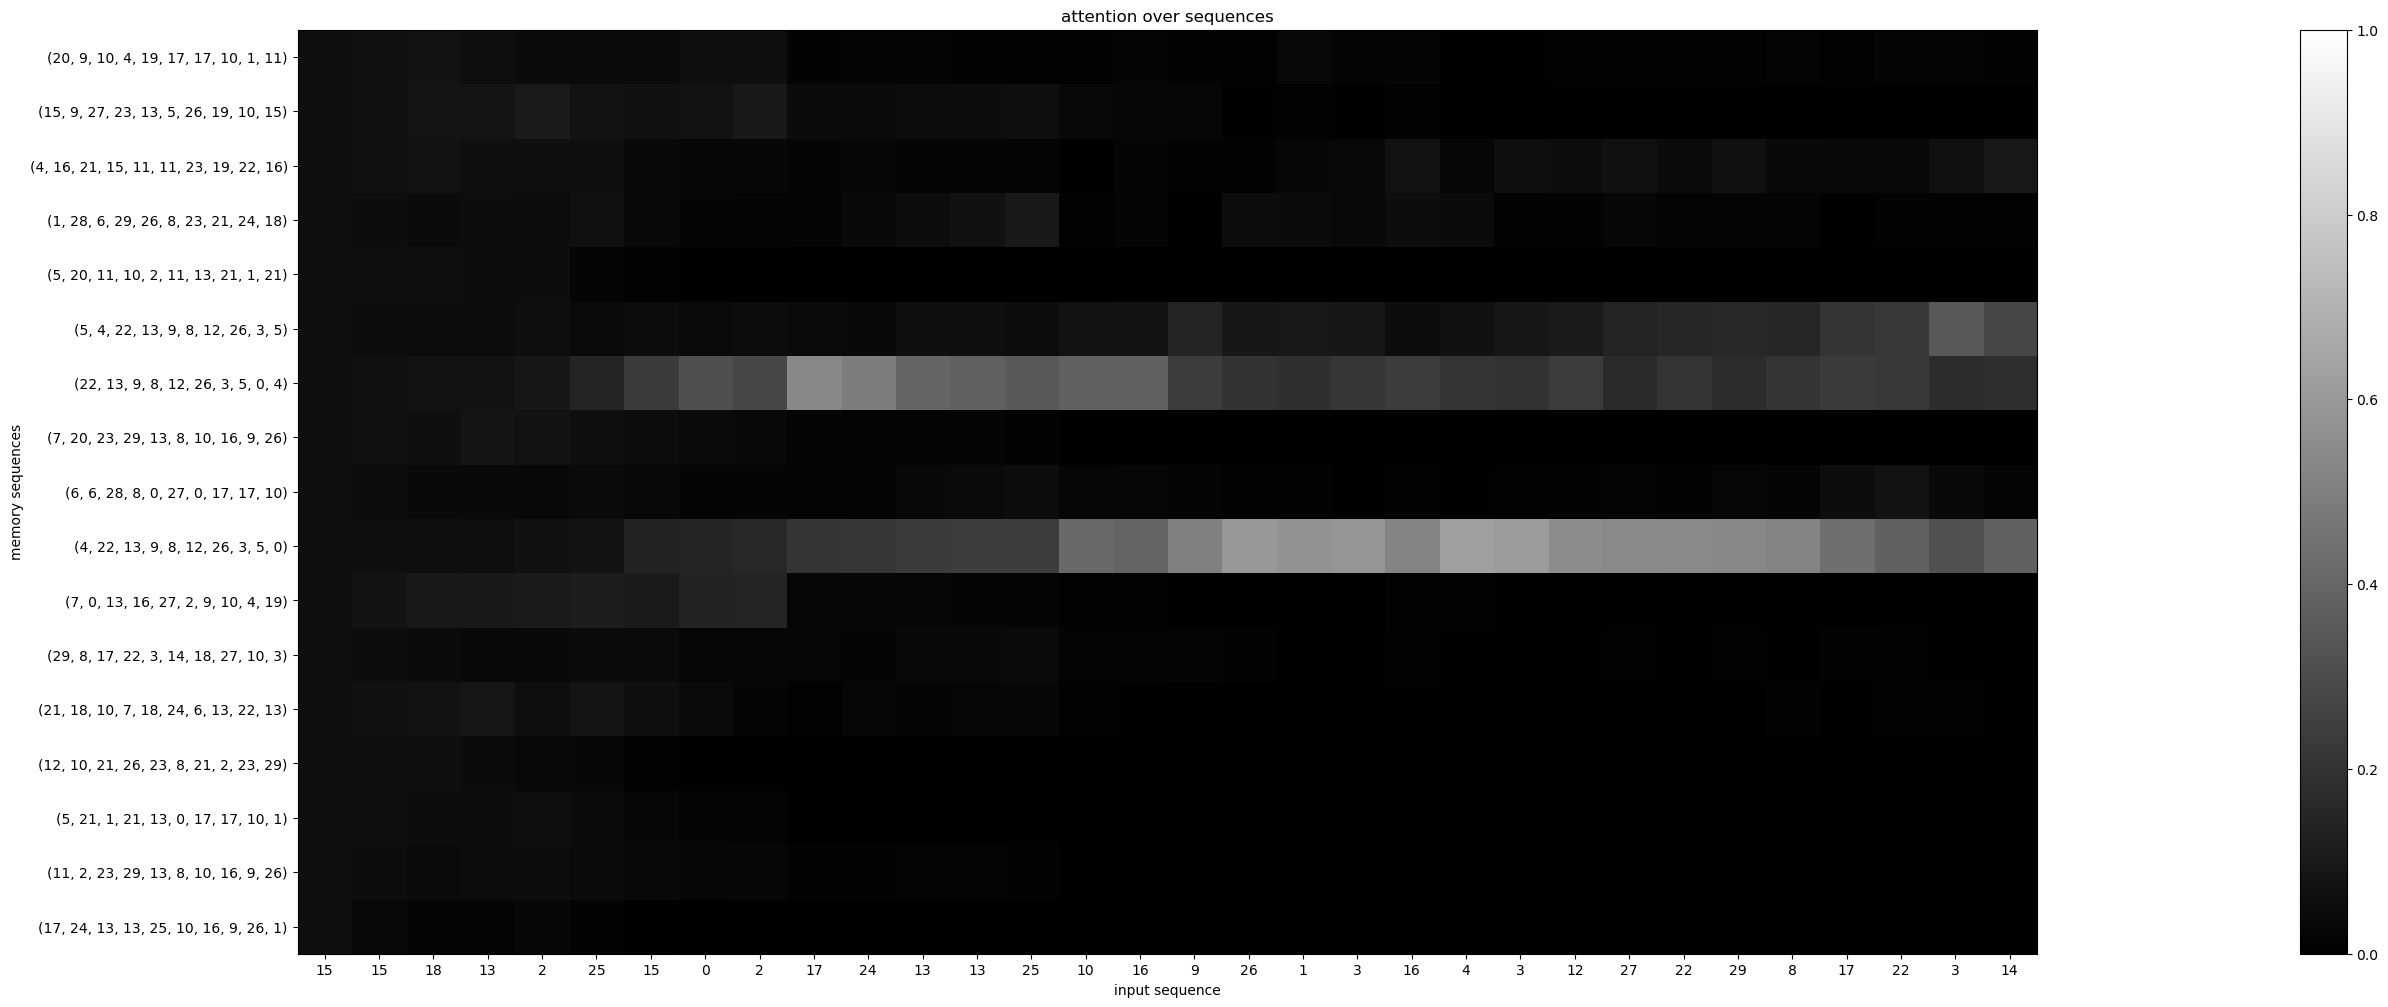

In [208]:
def plot_seq_attention(attn_, mem_seqs_x, train_seqs_x):
    num_mem_seqs = attn_.shape[0]
    fig, ax = plt.subplots(figsize=(num_mem_seqs*4,12))
    im = ax.imshow(attn_, cmap='gray', vmin=0, vmax=1)
    ax.set_yticks(range(len(mem_seqs_x)))
    ax.set_xticks(range(len(train_seqs_x)))
    ax.set_yticklabels([tuple(x) for x in mem_seqs_x]);
    ax.set_xticklabels(train_seqs_x);

    ax.set_xlabel('input sequence')
    ax.set_ylabel('memory sequences')
    ax.set_title('attention over sequences')

    fig.colorbar(im, ax=ax)
def print_gate_and_attn_cross_y(sample_input_index, seqs_x_train, seqs_y_train, mem_seqs_x_train, mem_seqs_y_train, memory_model):
    """
    choose sample input and plot the attention associated to the argmax probability vocab at each input position 
    (memory_seq versus each input element), call plot_seq_attention as subfunction
    """
    b = sample_input_index
    sample_input = seqs_x_train[b:b+1]
    print("sample_input: ",sample_input)
    sample_mem_seq_x = mem_seqs_x_train[b:b+1]
    sample_mem_seq_y = mem_seqs_y_train[b:b+1]

    pred = memory_model([sample_input, sample_mem_seq_x, sample_mem_seq_y])
    pred = np.argmax(pred, axis=-1)
    print(f'prediction: {pred[0]}')
    print(f'y: {seqs_y_train[b]}')
    print(pred[0] == seqs_y_train[b])
    attn_ = memory_model.alpha_it[0]
    gate = memory_model.gate[0]
    print("Gate:", gate.numpy().T)
    plot_seq_attention(attn_, sample_mem_seq_x[0], sample_input[0])

print_gate_and_attn_cross_y(10, seqs_x_train, seqs_y_train, mem_seqs_x_train, mem_seqs_y_train, kernel_model_gating)


kernel_model_gating
sample_input:  [[13 25 10 16  9 26  1  3 16  4  3 12 27 22 29  8 17 22  3 14 18 27 10  3
   4 10  5 23 27 20 28  2]]
prediction: [10 10 16  9 26  1  3 16  4  3 12 27 22 29  8 17 22  3 14 18 27 10  3  4
 10  5 23 27 20 28  2  3]
y: [25 10 16  9 26  1  3 16  4  3 12 27 22 29  8 17 22  3 14 18 27 10  3  4
 10  5 23 27 20 28  2  3]
[False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]
Gate: [[0.5125191  0.50087136 0.4361242  0.41474444 0.5808052  0.52325565
  0.5185225  0.41713813 0.58658606 0.5173497  0.44849086 0.43305722
  0.47076783 0.5223798  0.5772602  0.5130608  0.47741953 0.5188122
  0.52829003 0.5907709  0.42821464 0.5301975  0.51764023 0.6001444
  0.53062737 0.4143609  0.5404365  0.42878315 0.5208578  0.54195106
  0.44145083 0.5187623 ]]


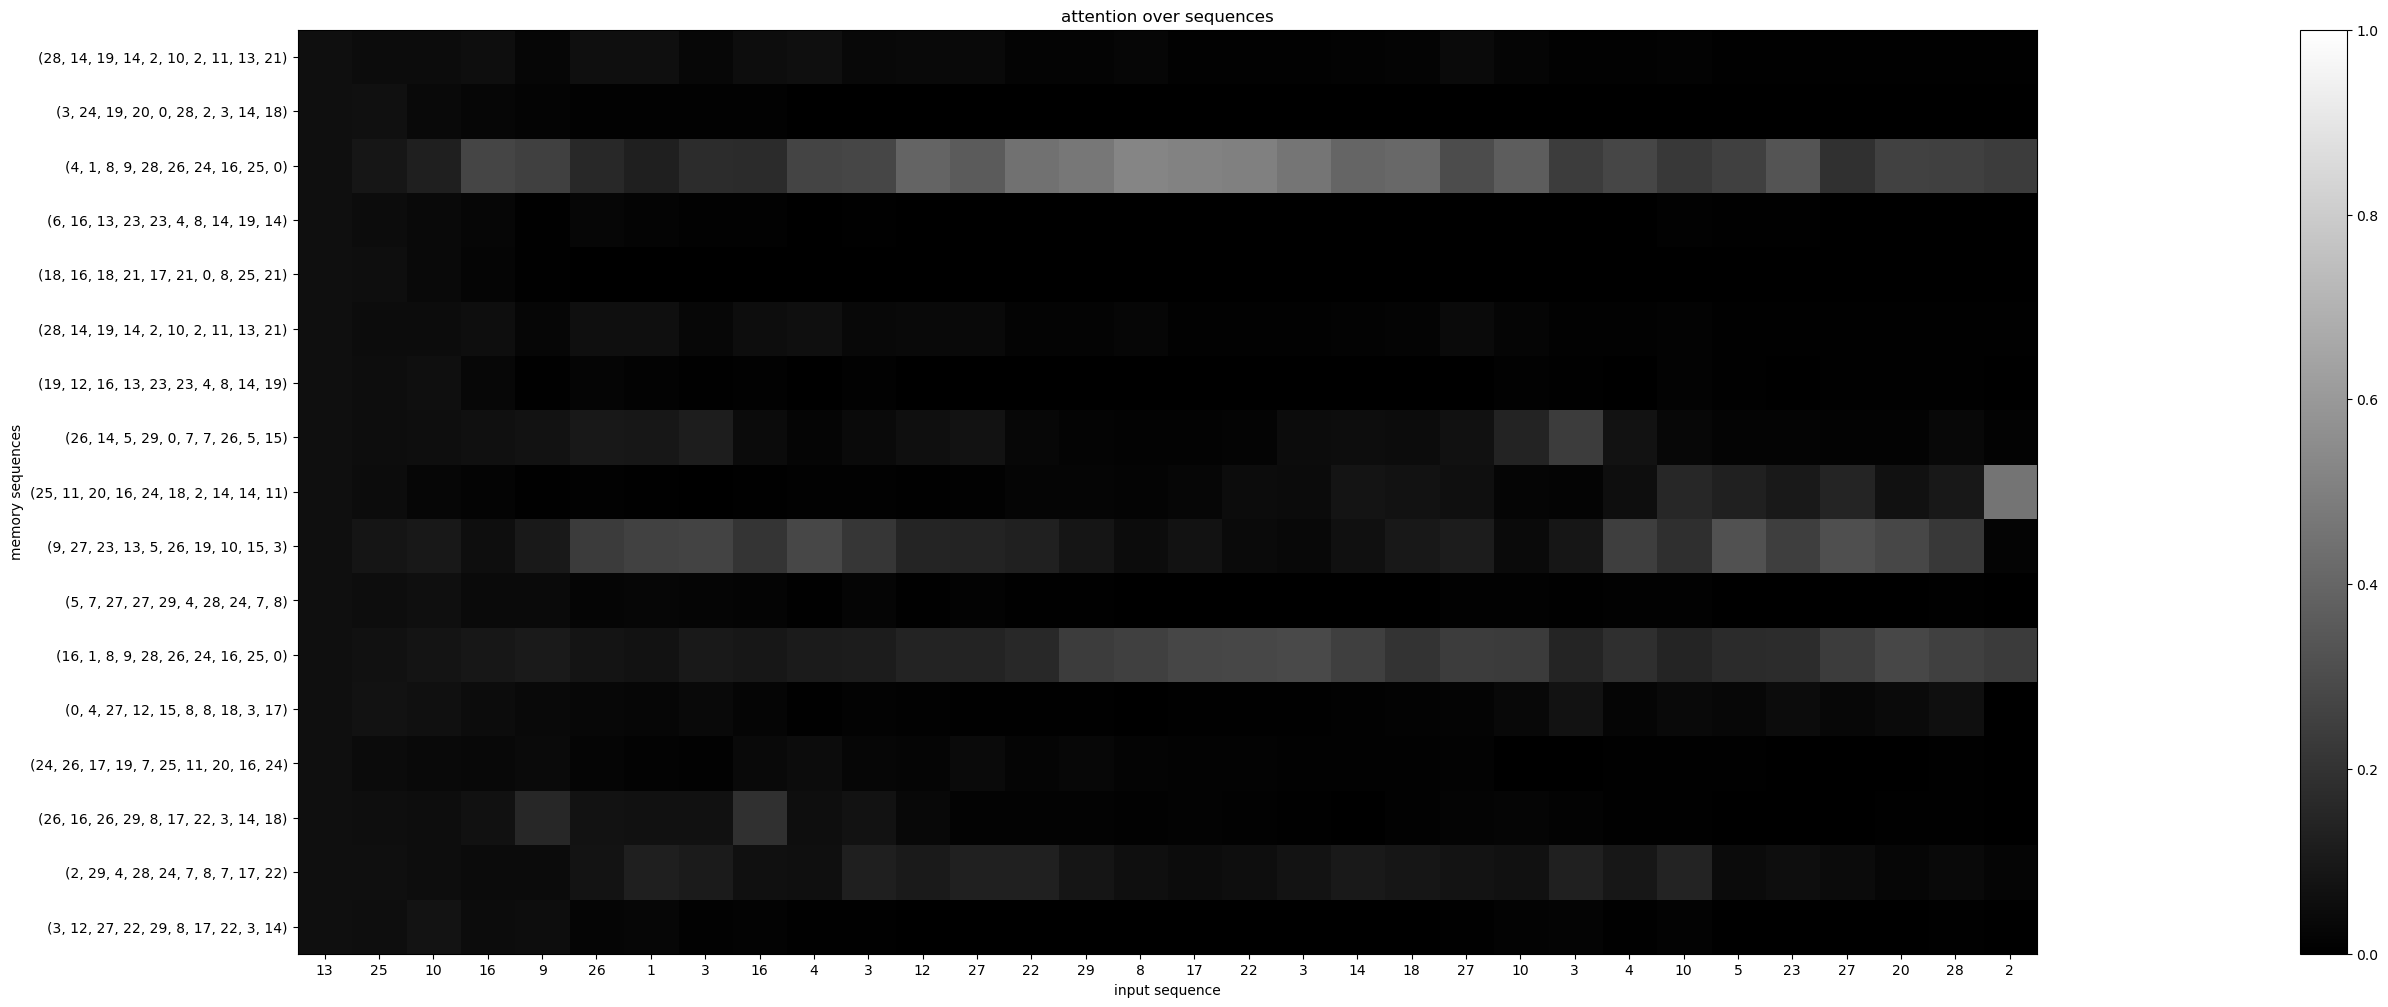

In [209]:
# change memory at inference time
mem_seqs_x_train, mem_seqs_y_train = zip(*[sample_mem_dataset(mem_seq_len, mem_size, input_seq, num_subseqs=1) for input_seq in seqs_x_train])
mem_seqs_x_test, mem_seqs_y_test = zip(*[sample_mem_dataset(mem_seq_len, mem_size, input_seq, num_subseqs=1) for input_seq in seqs_x_test])

mem_seqs_x_train, mem_seqs_y_train = np.array(mem_seqs_x_train), np.array(mem_seqs_y_train)
mem_seqs_x_test, mem_seqs_y_test = np.array(mem_seqs_x_test), np.array(mem_seqs_y_test)

idx = np.random.choice(len(seqs_x_test))
print('kernel_model_gating')

print_gate_and_attn_cross_y(idx, seqs_x_test, seqs_y_test, mem_seqs_x_test, mem_seqs_y_test, kernel_model_gating)


  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:10<00:00,  1.72s/it]


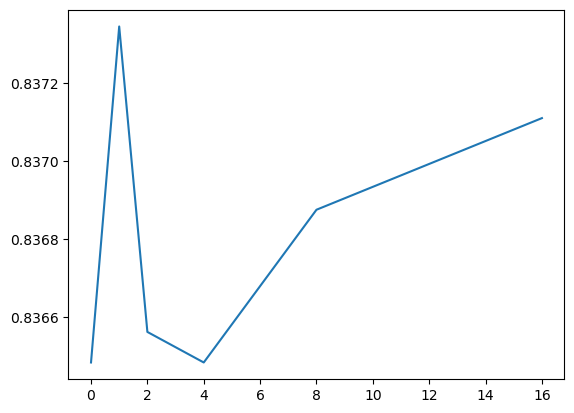

In [210]:
accs = []
nums_subseqs = [0, 1, 2, 4, 8, 16]
for num_subseqs in tqdm(nums_subseqs):
    mem_seqs_x_test, mem_seqs_y_test = zip(*[sample_mem_dataset(mem_seq_len, mem_size, input_seq, num_subseqs=num_subseqs) for input_seq in seqs_x_test])
    mem_seqs_x_test, mem_seqs_y_test = np.array(mem_seqs_x_test), np.array(mem_seqs_y_test)

    test_ds = tf.data.Dataset.from_tensor_slices(((seqs_x_test, mem_seqs_x_test, mem_seqs_y_test), seqs_y_test)).batch(64)
    _, acc = kernel_model_gating.evaluate(test_ds, verbose=0)
    accs.append(acc)

plt.plot(nums_subseqs, accs)